# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals
from IPython.core.debugger import set_trace

import cvxpy as cp
import networkx as nx
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from time import time
from typing import Text
import tensorflow as tf
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../src/')
import utils
import text_processor
import broadcast_network_extraction
from mytimer import Timer

/home/koasato/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/koasato/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/koasato/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/koasato/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

# Parameters

In [2]:
ERROR_TYPE_STR = 'mse'
LAMBDAA = 2
RUNS = 10
TEST_FRACTION = 0.2

In [3]:
net_extractor = broadcast_network_extraction.NetworkExtraction()
content_fixer = text_processor.FormalEnglishTranslator('../bagofwords/slang.txt')

In [4]:
directory = '/home/koasato/Documents/research/Jeopardy/'
data = None
try:
    data = utils.load_it(directory + 'Teams_logs.pk')
except:
    print("ERROR")

print(len(data))

49


In [5]:
combined_logs = {}
for team_id, team_log in data.items():
    print("Processing team", team_id, '...')
    this_team_nets = []
    this_team_number_of_networks = min(
        len(team_log.messages) // 5,
        len(team_log.member_influences))
    all_messages_before_appraisal_reports = []
    for i in range(this_team_number_of_networks):
        all_messages_before_appraisal_reports.append(
            pd.concat(
                [team_log.messages[i] for i in np.arange(i * 5, i * 5 + 5)]))
    if len(all_messages_before_appraisal_reports) > 0:
        combined_logs[team_id] = all_messages_before_appraisal_reports
    else:
        print('Team', team_id, 'does not have enough logs.')

Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 35 ...
Team 35 does not have enough logs.
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 72 ...
Team 72 does not have enough logs.
Processing team 73 ...
Team 73 doe

In [6]:
size = 25
mean_total_error = np.zeros(shape=(size,size))
std_total_error = np.zeros(shape=(size,size))
model_errs = []
with Timer():
    for b in range(0, size):
        for e in range(0, size):
            if b >= e:
                continue
            time_window = [b, e]
            cumulative_mse_for_time_window = 0
            counter = 0

            X = []
            y = []
            print("time window = ", time_window)
            for team_id, all_messages_before_appraisal_reports in combined_logs.items():
                members = data[team_id].members
                print("Processing team", team_id, '...')
                this_team_nets = []

                for index, all_messages_before_appraisal_report in enumerate(all_messages_before_appraisal_reports):
                    reply_duration_net = net_extractor.extract_network_from_broadcast(            
                        communication_data=all_messages_before_appraisal_report,
                        time_window=time_window,
                        weight_type=broadcast_network_extraction.WeightType.REPLY_DURATION,
                        aggregation_type=broadcast_network_extraction.AggregationType.SUM,
                        gamma=2,
                        node_list=members)
                    influence_matrix = np.matrix(data[team_id].member_influences[index])
                    to_be_predicted_influence_matrix = utils.shuffle_matrix_in_given_order(
                            matrix=influence_matrix,
                            order=np.argsort(members)) / 100
                    # Use reply_duration_net to predict to_be_predicted_influence_matrix
                    reply_duration_net_matrix = nx.adj_matrix(reply_duration_net).todense()

                    X.append(reply_duration_net_matrix)
                    y.append(to_be_predicted_influence_matrix)

            model_err = []
            for run in range(RUNS):
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=TEST_FRACTION)

                # Solving the optimization problem.
                W = cp.Variable((4, 4))
                B = cp.Variable((4, 4))

                constraints = []
                losses = 0
                for index in range(len(X_train)):
                    A = X_train[index]
                    influence_matrix = y_train[index]
                    pred_influence_matrix = A * W + B
                    
                    if (ERROR_TYPE_STR == 'mse'):
                        losses += cp.sum_squares(pred_influence_matrix - influence_matrix)
                    else:
                        raise ValueError("Incorrect ERROR_TYPE_STR")
                        
                    constraints += [pred_influence_matrix >= 0]
                    constraints += [cp.sum(pred_influence_matrix, axis=1) == 1]
                regluarization = cp.norm1(W) + cp.norm1(B)
                objective = cp.Minimize(losses + LAMBDAA * regluarization)
                prob = cp.Problem(objective, constraints)
                try:
                    result = prob.solve()
                except cp.SolverError as e:
                    print('Problem was not solved for lambda: {}'.format(LAMBDAA))
    #                 return sys.maxsize, sys.maxsize
                print('The status of solution was: {} and the result was: {}'.format(prob.status, result))

                model_err = 0
                for index in range(len(X_test)):
                    A = X_test[index]
                    influence_matrix = y_test[index]
                    # Optimization model prediction:
                    predicted_influence_matrix = (A * W.value + B.value)
                    model_err += utils.matrix_estimation_error(
                        influence_matrix, predicted_influence_matrix, type_str=ERROR_TYPE_STR)
                model_errs.append(model_err)

            mean_total_error[b][e] = np.mean(model_errs)
            std_total_error[b][e] = np.std(model_errs)

time window =  [0, 1]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing te

Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 65.58301213603563
The status of solution was: optimal and the result was: 60.570097038262446
The status of solution was: optimal and the result was: 62.89856125629211
The status of solution was: optimal and the result was: 60.01269873012166
The status of solution was: optimal and the result was: 62.89960953030003
The status of solution was: optimal and the result was: 63.241756266243705
The status of solution was: optimal and the result was: 61.69268529234651
The status of solution was: optimal and the result was: 63.9357922416376
The status of solution was: optimal and the result was: 63.65771107001103
The status of solution was: optimal and the result was: 61.763816407200295
time window =  [0, 6]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Process

Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing 

Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 62.4314715817319
The status of solution was: optimal and the result was: 60.295690835794716
The status of solution was: optimal and the result was: 63.04030220093048
The status of solution was: optimal and the result was: 63.87728508532576
The status of solution was: optimal and the result was: 62.982034201110075
The status of solution was: optimal and the result was: 61.43098806284982
The status of solution was: optimal and the result was: 62.6955251302048
The status of solution was: optimal and the result was: 60.91664351899769
The status of solution was: optimal and the result was: 60.41496016297015
The status of solution was: optimal and the result was: 64.06000043112684
time window =  [0, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processi

Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status 

Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.709579827225504
The status of solution was: optimal and the result was: 62.765510886930215
The status of solution was: optimal and the result was: 59.6001954656112
The status of solution was: optimal and the result was: 59.93144245017244
The status of solution was: optimal and the result was: 58.3061315697072
The status of solution was: optimal and the result was: 61.09645102471175
The status of solution was: optimal and the result was: 62.13410429485629
The status of solution was: optimal and the result was: 62.30895563019696
The status of solution was: optimal and the result was: 64.97976204116094
The status of solution was: optimal and the result was: 60.31489135849458
time window =  [0, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processi

Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 6

Processing team 88 ...
The status of solution was: optimal and the result was: 64.44979265799239
The status of solution was: optimal and the result was: 59.84446003717562
The status of solution was: optimal and the result was: 65.2855697026026
The status of solution was: optimal and the result was: 61.23611579925706
The status of solution was: optimal and the result was: 63.44684126394059
The status of solution was: optimal and the result was: 64.27208949814178
The status of solution was: optimal and the result was: 61.66323169145007
The status of solution was: optimal and the result was: 61.84637973977714
The status of solution was: optimal and the result was: 64.00092137546486
The status of solution was: optimal and the result was: 62.41603327137575
time window =  [1, 10]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processin

Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.632090799256254
The status of solution was: 

The status of solution was: optimal and the result was: 66.37734804832684
The status of solution was: optimal and the result was: 63.37012546468382
The status of solution was: optimal and the result was: 62.9190500929367
The status of solution was: optimal and the result was: 64.52603066914456
The status of solution was: optimal and the result was: 63.64062249070652
The status of solution was: optimal and the result was: 63.00235920074295
The status of solution was: optimal and the result was: 61.24938745353121
The status of solution was: optimal and the result was: 64.56262369888567
The status of solution was: optimal and the result was: 62.63561459107868
time window =  [1, 19]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing tea

Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.75907676579945
The status of solution was: optimal and the result was: 61.68151552044616
The status of solution was: optimal and the res

The status of solution was: optimal and the result was: 60.52964972118915
The status of solution was: optimal and the result was: 62.888452137546885
The status of solution was: optimal and the result was: 62.26498392193236
The status of solution was: optimal and the result was: 62.22669247211905
The status of solution was: optimal and the result was: 61.96285446096658
The status of solution was: optimal and the result was: 61.02999804832744
The status of solution was: optimal and the result was: 61.40414098513005
The status of solution was: optimal and the result was: 61.36989563197021
time window =  [2, 6]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30

Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 64.46394321561311
The status of solution was: optimal and the result was: 61.85080799256525
The status of solution was: optimal and the result was: 60.71398466542735
The status of solut

The status of solution was: optimal and the result was: 62.57639507435008
The status of solution was: optimal and the result was: 64.43181301115229
The status of solution was: optimal and the result was: 62.99308940520424
The status of solution was: optimal and the result was: 61.85207109665403
The status of solution was: optimal and the result was: 62.6570469330852
The status of solution was: optimal and the result was: 62.07851236059444
The status of solution was: optimal and the result was: 58.11037053903387
time window =  [2, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
P

Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 64.7047988847587
The status of solution was: optimal and the result was: 61.791270539033256
The status of solution was: optimal and the result was: 64.46653782527852
The status of solution was: optimal and the result was: 59.53303057620765
The status of solution was: optimal a

The status of solution was: optimal and the result was: 62.315214033457984
The status of solution was: optimal and the result was: 63.44457369888469
The status of solution was: optimal and the result was: 61.625383550186456
The status of solution was: optimal and the result was: 62.47261552044634
The status of solution was: optimal and the result was: 59.70138494423782
The status of solution was: optimal and the result was: 64.50592137546487
time window =  [2, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Pro

Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 60.07220334572437
The status of solution was: optimal and the result was: 63.8050555762081
The status of solution was: optimal and the result was: 62.89771700743503
The status of solution was: optimal and the result was: 61.95129609665419
The status of solution was: optimal and the result was: 64.1247736988847
The status of solution was: optima

The status of solution was: optimal and the result was: 62.929768215613244
The status of solution was: optimal and the result was: 64.89708977695174
The status of solution was: optimal and the result was: 60.02530650557614
The status of solution was: optimal and the result was: 63.126421375464446
The status of solution was: optimal and the result was: 62.13963159851293
time window =  [3, 12]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processi

Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 64.24787685873655
The status of solution was: optimal and the result was: 65.4197337360599
The status of solution was: optimal and the result was: 63.28055808550179
The status of solution was: optimal and the result was: 63.48457657992602
The status of solution was: optimal and the result was: 60.435850836431264
The status of solution was: optimal and the result was: 60.46757481412649
The status of solution was:

The status of solution was: optimal and the result was: 63.40511468401415
The status of solution was: optimal and the result was: 62.44310111524159
The status of solution was: optimal and the result was: 65.40718605947939
The status of solution was: optimal and the result was: 61.216495353160006
time window =  [3, 21]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing tea

Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.65969488847501
The status of solution was: optimal and the result was: 62.29656022304781
The status of solution was: optimal and the result was: 63.22410585501817
The status of solution was: optimal and the result was: 60.96853912639449
The status of solution was: optimal and the result was: 63.656423977695695
The status of solution was: optimal and the result was: 61.94131988847496
The status of solution was: optimal and the result was: 60.11642193308503
The status of solutio

The status of solution was: optimal and the result was: 64.83095288104137
The status of solution was: optimal and the result was: 61.49672555762037
The status of solution was: optimal and the result was: 62.77786737918283
time window =  [4, 10]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 .

Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 60.237419702601834
The status of solution was: optimal and the result was: 61.15470548327063
The status of solution was: optimal and the result was: 63.11575604089196
The status of solution was: optimal and the result was: 59.853893587360666
The status of solution was: optimal and the result was: 63.63571542750913
The status of solution was: optimal and the result was: 63.92599014869947
The status of solution was: optimal and the result was: 62.66139172862455
The status of solution was: optimal and the result was: 63.730414776952074
The status of 

The status of solution was: optimal and the result was: 62.51572918215685
The status of solution was: optimal and the result was: 61.80159767657962
The status of solution was: optimal and the result was: 64.77532695167224
time window =  [4, 19]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 .

Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 64.35578048327093
The status of solution was: optimal and the result was: 63.390699721189996
The status of solution was: optimal and the result was: 63.20937741635712
The status of solution was: optimal and the result was: 60.900840985129925
The status of solution was: optimal and the result was: 59.8680261152416
The status of solution was: optimal and the result was: 64.92541700743428
The status of solution was: optimal and the result was: 63.130055669143964
The status of solution was: optimal and the result was: 60.54240167286212
The status of s

The status of solution was: optimal and the result was: 61.91629265799296
The status of solution was: optimal and the result was: 63.65928605947908
time window =  [5, 9]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Pro

Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 65.27633866171004
The status of solution was: optimal and the result was: 61.71536477695198
The status of solution was: optimal and the result was: 62.293654368030296
The status of solution was: optimal and the result was: 63.32035492565113
The status of solution was: optimal and the result was: 62.30943847583639
The status of solution was: optimal and the result was: 61.05318838289991
The status of solution was: optimal and the result was: 63.48292211895871
The status of solution was: optimal and the result was: 64.45052351301088
The status of solution was: optimal and the result was: 61.334300557620175
The status

The status of solution was: optimal and the result was: 64.88676263940559
The status of solution was: optimal and the result was: 60.06354981412614
time window =  [5, 18]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Pr

Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.93548689591119
The status of solution was: optimal and the result was: 63.84129879182161
The status of solution was: optimal and the result was: 62.76081644981437
The status of solution was: optimal and the result was: 61.43314693308552
The status of solution was: optimal and the result was: 63.442978159851016
The status of solution was: optimal and the result was: 63.32335185873562
The status of solution was: optimal and the result was: 61.014353531598765
The status of solution was: optimal and the result was: 63.227971468401556
The status of solution was: optimal and the result was: 61.27631700743464
The status of solution was: opti

The status of solution was: optimal and the result was: 63.5531816914496
time window =  [6, 9]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processin

Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 62.724511338290185
The status of solution was: optimal and the result was: 66.09569944237899
The status of solution was: optimal and the result was: 62.86063252787995
The status of solution was: optimal and the result was: 60.347387918215304
The status of solution was: optimal and the result was: 60.497755669144816
The status of solution was: optimal and the result was: 61.39090743494367
The status of solution was: optimal and the result was: 60.121199070631704
The status of solution was: optimal and the result was: 62.855096840148605
The status of solution was: optimal and the result was: 60.36625697026027
The status of solution was: optimal and the result was: 62.81295074349359
time window =  [6, 14]
Pr

Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing 

Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.84899433085589
The status of solution was: optimal and the result was: 63.18078178438617
The status of solution was: optimal and the result was: 65.67994972118849
The status of solution was: optimal and the result was: 62.94793726765757
The status of solution was: optimal and the result was: 64.8555119888479
The status of solution was: optimal and the result was: 61.84659126394088
The status of solution was: optimal and the result was: 61.61411096654317
The status of solution was: optimal and the result was: 61.107960966542954
The status of solution was: optimal and the result was: 62.72746858736031
The status of solution was: optimal and the result was: 64.34931217472037
time window =  [6, 23]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processi

Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status 

Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 60.81342983271304
The status of solution was: optimal and the result was: 61.97113838289955
The status of solution was: optimal and the result was: 63.38498373605929
The status of solution was: optimal and the result was: 61.17653252788135
The status of solution was: optimal and the result was: 63.751424442378884
The status of solution was: optimal and the result was: 60.96028345724961
The status of solution was: optimal and the result was: 64.89383847583674
The status of solution was: optimal and the result was: 62.48703968401557
The status of solution was: optimal and the result was: 61.8233493494426
The status of solution was: optimal and the result was: 59.43121431226825
time window =  [7, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processi

Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 6

Processing team 88 ...
The status of solution was: optimal and the result was: 59.770729368029706
The status of solution was: optimal and the result was: 62.34317128252878
The status of solution was: optimal and the result was: 61.85127918215693
The status of solution was: optimal and the result was: 60.66171171003759
The status of solution was: optimal and the result was: 60.49902360594795
The status of solution was: optimal and the result was: 61.4479059479553
The status of solution was: optimal and the result was: 61.91325789962784
The status of solution was: optimal and the result was: 63.68473289962897
The status of solution was: optimal and the result was: 61.347559944237645
The status of solution was: optimal and the result was: 61.59933327137592
time window =  [7, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Process

Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 59.07991737918221
The status of solution was: o

The status of solution was: optimal and the result was: 61.960375929368496
The status of solution was: optimal and the result was: 63.036905390335335
The status of solution was: optimal and the result was: 61.05047156133865
The status of solution was: optimal and the result was: 61.301260780669196
The status of solution was: optimal and the result was: 61.71594163568823
The status of solution was: optimal and the result was: 61.95421914498132
The status of solution was: optimal and the result was: 62.931397862453075
The status of solution was: optimal and the result was: 60.76260018587318
The status of solution was: optimal and the result was: 63.95489451672837
time window =  [8, 17]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processin

Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.14864042750907
The status of solution was: optimal and the result was: 62.09122239776996
The status of solution was: optimal and the res

The status of solution was: optimal and the result was: 61.54898745353145
The status of solution was: optimal and the result was: 61.860911988848166
The status of solution was: optimal and the result was: 59.63036143122689
The status of solution was: optimal and the result was: 61.432774070632114
The status of solution was: optimal and the result was: 64.35433996282507
The status of solution was: optimal and the result was: 64.6997162639398
The status of solution was: optimal and the result was: 62.94410985130208
The status of solution was: optimal and the result was: 64.22759730483214
time window =  [9, 11]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 3

Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.4455859665429
The status of solution was: optimal and the result was: 64.37682221189635
The status of solution was: optimal and the result was: 63.43687100371791
The status of soluti

The status of solution was: optimal and the result was: 63.94405260223016
The status of solution was: optimal and the result was: 65.765649442379
The status of solution was: optimal and the result was: 61.506288661709974
The status of solution was: optimal and the result was: 60.55069200743485
The status of solution was: optimal and the result was: 61.49048001858775
The status of solution was: optimal and the result was: 62.73337016728638
The status of solution was: optimal and the result was: 60.61286301115284
time window =  [9, 20]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
P

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.59213020446139
The status of solution was: optimal and the result was: 63.21103810408978
The status of solution was: optimal and the result was: 61.032671747212355
The status of solution was: optimal and the result was: 65.15706440520417
The status of

The status of solution was: optimal and the result was: 62.509080111524106
The status of solution was: optimal and the result was: 61.097413011152746
The status of solution was: optimal and the result was: 62.05846189591098
The status of solution was: optimal and the result was: 61.1974724907055
The status of solution was: optimal and the result was: 61.28412146840202
The status of solution was: optimal and the result was: 64.24661133828991
The status of solution was: optimal and the result was: 63.89707276951633
time window =  [10, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ..

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.72809618959073
The status of solution was: optimal and the result was: 59.77757304832689
The status of solution was: optimal and the result was: 60.56903513011229
The status of solution was: optimal and the result was: 63.4230051115243
The status of s

The status of solution was: optimal and the result was: 63.39859423791893
The status of solution was: optimal and the result was: 63.022547118959636
The status of solution was: optimal and the result was: 63.14122732341978
The status of solution was: optimal and the result was: 61.01352007434927
The status of solution was: optimal and the result was: 57.98286988847597
The status of solution was: optimal and the result was: 61.47807778810419
The status of solution was: optimal and the result was: 65.203313754647
time window =  [10, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...


Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.55084711895908
The status of solution was: optimal and the result was: 62.379417657992775
The status of solution was: optimal and the result was: 62.08155427509338
The status of solution was: optimal and the result was: 63.90336105947967
The status of

The status of solution was: optimal and the result was: 59.54317723048337
The status of solution was: optimal and the result was: 62.14976942379196
The status of solution was: optimal and the result was: 60.18632295539023
The status of solution was: optimal and the result was: 61.168535687731485
The status of solution was: optimal and the result was: 62.70748977695196
The status of solution was: optimal and the result was: 61.33195715613371
The status of solution was: optimal and the result was: 63.95979042750946
time window =  [11, 20]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ..

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 60.79728828996292
The status of solution was: optimal and the result was: 64.43682862453544
The status of solution was: optimal and the result was: 67.65065306691466
The status of solution was: optimal and the result was: 63.394502788103416
The status of

The status of solution was: optimal and the result was: 62.849034758363416
The status of solution was: optimal and the result was: 62.090417750929404
The status of solution was: optimal and the result was: 62.94626951672865
The status of solution was: optimal and the result was: 62.76899098513002
The status of solution was: optimal and the result was: 64.98055827137556
The status of solution was: optimal and the result was: 62.944280390334484
The status of solution was: optimal and the result was: 61.515464498142386
time window =  [12, 17]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 63.22273596654316
The status of solution was: optimal and the result was: 62.8211101301112
The status of solution was: optimal and the result was: 64.38415390334444
The status of solution was: optimal and the result was: 61.284616728624286
The status of 

The status of solution was: optimal and the result was: 62.768914405203624
The status of solution was: optimal and the result was: 63.1999460037173
The status of solution was: optimal and the result was: 61.81353550185785
The status of solution was: optimal and the result was: 62.014031412639014
The status of solution was: optimal and the result was: 62.13589163568813
The status of solution was: optimal and the result was: 63.31459312267772
The status of solution was: optimal and the result was: 64.42849665427475
time window =  [13, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ..

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.833315241635425
The status of solution was: optimal and the result was: 61.33963587360606
The status of solution was: optimal and the result was: 63.34277964683989
The status of solution was: optimal and the result was: 60.927840706319024
The status o

The status of solution was: optimal and the result was: 63.5693431226768
The status of solution was: optimal and the result was: 61.695551486988826
The status of solution was: optimal and the result was: 60.246057342007234
The status of solution was: optimal and the result was: 63.89322286245352
The status of solution was: optimal and the result was: 61.6339623605947
The status of solution was: optimal and the result was: 60.65447397769522
The status of solution was: optimal and the result was: 61.53622509293721
time window =  [13, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 62.848716356877276
The status of solution was: optimal and the result was: 59.8895726765805
The status of solution was: optimal and the result was: 64.99914144981437
The status of solution was: optimal and the result was: 64.31674442379261
The status of 

The status of solution was: optimal and the result was: 63.7495868029754
The status of solution was: optimal and the result was: 62.27258262081871
The status of solution was: optimal and the result was: 62.19664749070621
The status of solution was: optimal and the result was: 60.814219516728464
The status of solution was: optimal and the result was: 64.83853578067013
The status of solution was: optimal and the result was: 62.7001592936811
The status of solution was: optimal and the result was: 63.729250929367815
time window =  [14, 23]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 59.77938206319748
The status of solution was: optimal and the result was: 61.89791440520433
The status of solution was: optimal and the result was: 63.55586198884739
The status of solution was: optimal and the result was: 62.626198327137985
The status of

The status of solution was: optimal and the result was: 63.25275669145035
The status of solution was: optimal and the result was: 64.49740381040871
The status of solution was: optimal and the result was: 61.86277936802982
The status of solution was: optimal and the result was: 60.67403131970287
The status of solution was: optimal and the result was: 64.71465678438693
The status of solution was: optimal and the result was: 61.364018029740166
The status of solution was: optimal and the result was: 62.25345325278768
time window =  [15, 23]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ..

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 62.16757834572536
The status of solution was: optimal and the result was: 64.65685315985112
The status of solution was: optimal and the result was: 61.40301226765803
The status of solution was: optimal and the result was: 64.3524308550192
The status of s

The status of solution was: optimal and the result was: 62.547816449813354
The status of solution was: optimal and the result was: 60.012434758364385
The status of solution was: optimal and the result was: 62.58212397769551
The status of solution was: optimal and the result was: 62.58254405204437
The status of solution was: optimal and the result was: 63.935021189590316
The status of solution was: optimal and the result was: 61.39123262081861
The status of solution was: optimal and the result was: 63.51789433085521
time window =  [16, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 64.0024456319704
The status of solution was: optimal and the result was: 62.46944972118909
The status of solution was: optimal and the result was: 62.60414814126382
The status of solution was: optimal and the result was: 63.2240910780673
The status of so

The status of solution was: optimal and the result was: 61.027699163569
The status of solution was: optimal and the result was: 65.5678539033462
The status of solution was: optimal and the result was: 61.77388187732344
The status of solution was: optimal and the result was: 61.098638475836296
The status of solution was: optimal and the result was: 61.736444052044426
The status of solution was: optimal and the result was: 64.44066691449845
The status of solution was: optimal and the result was: 60.11592611524169
time window =  [18, 20]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...


Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 62.769202137546195
The status of solution was: optimal and the result was: 63.45930836431252
The status of solution was: optimal and the result was: 60.58338048327108
The status of solution was: optimal and the result was: 63.71653587360564
The status of

The status of solution was: optimal and the result was: 60.92894405204432
The status of solution was: optimal and the result was: 62.84040130111495
The status of solution was: optimal and the result was: 61.04138680297468
The status of solution was: optimal and the result was: 63.50535148698904
The status of solution was: optimal and the result was: 59.45550548327148
The status of solution was: optimal and the result was: 60.259195353159654
The status of solution was: optimal and the result was: 62.13806942379159
time window =  [19, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ..

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
The status of solution was: optimal and the result was: 61.982525371747826
The status of solution was: optimal and the result was: 60.85924405204473
The status of solution was: optimal and the result was: 63.67557685873593
The status of solution was: optimal and the result was: 61.80522723048322
The status of

The status of solution was: optimal and the result was: 62.34904851301076
The status of solution was: optimal and the result was: 62.29504563196997
The status of solution was: optimal and the result was: 59.479470817844245
The status of solution was: optimal and the result was: 61.74693224907074
The status of solution was: optimal and the result was: 62.103324070632
The status of solution was: optimal and the result was: 63.51049526022224
The status of solution was: optimal and the result was: 62.17409182156154
time window =  [22, 24]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...


In [19]:
utils.save_it(mean_total_error, directory+'Time_Window_Error_mse_lambda2_gamma2.pk', verbose=True)
utils.save_it(std_total_error, directory+'Time_Window_Std_mse_lambda2_gamma2.pk', verbose=True)

/home/koasato/Documents/research/Jeopardy/Time_Window_Error_mse_lambda2_gamma2.pk is successfully saved.
/home/koasato/Documents/research/Jeopardy/Time_Window_Std_mse_lambda2_gamma2.pk is successfully saved.


In [18]:
# mean_total_error = utils.load_it(directory+'Time_Window_Error_mse_lambda5_gamma1.pk',verbose=True)
# std_total_error = utils.load_it(directory+'Time_Window_Std_mse_lambda5_gamma1.pk',verbose=True)


/home/koasato/Documents/research/Jeopardy/Time_Window_Error_mse_lambda5_gamma1.pk is successfully loaded.


FileNotFoundError: [Errno 2] No such file or directory: '/home/koasato/Documents/research/Jeopardy/Time_Window_Std_mse_lambda5_gamma1.pk'

In [9]:
print(mean_total_error)

[[0.         0.89881793 0.87385519 0.87541227 0.86186283 0.85689097
  0.84928865 0.84528381 0.84638199 0.85601649 0.8588756  0.8613336
  0.86240004 0.86701747 0.86680269 0.8650297  0.86223269 0.86216621
  0.85913498 0.85915517 0.85974129 0.86070799 0.86062741 0.86268962
  0.86386439]
 [0.         0.         0.86166674 0.8608269  0.86229942 0.86276048
  0.86278635 0.86288719 0.8639068  0.86323953 0.86271809 0.86343176
  0.86334431 0.86410121 0.8640761  0.86365492 0.86520362 0.86468375
  0.86330907 0.86496954 0.86544079 0.86595717 0.86425117 0.8649129
  0.86465284]
 [0.         0.         0.         0.86499917 0.86415727 0.86463743
  0.86441233 0.86430761 0.8645654  0.86429422 0.8644248  0.86344833
  0.86427595 0.86442664 0.8647017  0.8657186  0.86553073 0.86511491
  0.86548636 0.86656489 0.8660583  0.86653264 0.86652435 0.86659679
  0.86583712]
 [0.         0.         0.         0.         0.86619904 0.86704754
  0.8671015  0.86728469 0.86718814 0.86677603 0.86691553 0.86676286
  0.8674

In [10]:
print(std_total_error)

[[0.         0.05783466 0.07735335 0.08676886 0.08612405 0.08935005
  0.08967245 0.09150421 0.09126677 0.09591793 0.09641115 0.09520417
  0.09438191 0.10066091 0.099414   0.0981706  0.09735365 0.09717926
  0.09907495 0.09859428 0.09815014 0.09771411 0.09867137 0.10018288
  0.09978409]
 [0.         0.         0.09941721 0.09998731 0.10004953 0.10139823
  0.10108676 0.10173979 0.10157314 0.1016262  0.10217904 0.10227233
  0.10251491 0.10244482 0.10198455 0.10104859 0.10239009 0.10218256
  0.10226383 0.10300272 0.10251746 0.10165966 0.10232605 0.10193693
  0.10179366]
 [0.         0.         0.         0.10184333 0.10162299 0.10122139
  0.10136809 0.1008572  0.10044008 0.10015877 0.10016379 0.09993891
  0.10050338 0.10042997 0.10046556 0.10016069 0.10005653 0.09990736
  0.09975521 0.10043877 0.09996797 0.09986392 0.09977476 0.09984734
  0.09984037]
 [0.         0.         0.         0.         0.09985112 0.10014109
  0.10008165 0.09982469 0.10004555 0.09994232 0.10000302 0.10018091
  0.10

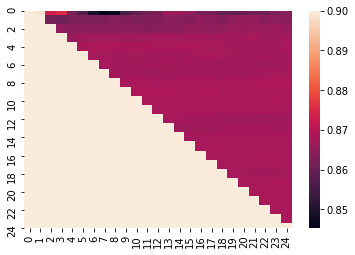

In [17]:
mean_total_error[mean_total_error == .12] = .9
import seaborn as sns
import matplotlib.pylab as plt
sns.heatmap(mean_total_error)
plt.show()

In [12]:
np.min(mean_total_error)

0.8452838052848552

In [13]:
np.where(mean_total_error == np.min(mean_total_error))

(array([0]), array([7]))

In [14]:
# best window for mse = 4,5
# best window for cosine = 0,2
# best window for normalized = 0, 1
# best window for cosine_0.01 = 0, 5

# best window for mse gamma 0.3 lambda 0.1 = 0,1
# best window for mse gamma 0.5 lambda 0.1 = 0,1
# best window for mse gamma 1 lambda 0.1 = 7, 22
# best window for mse gamma 3 lambda 0.1 = 0, 2
# best window for mse gamma 5 lambda 0.1 = 0, 1
# best window for mse gamma 10 lambda 0.1 = 0, 1

# best window for mse gamma 0.5 lambda 0.5 = 0, 2
# best window for mse gamma 0.5 lambda 1 = 0, 1
# best window for mse gamma 0.5 lambda 2 = 0, 5
# best window for mse gamma 0.5 lambda 5 = 0, 9

# best window for mse gamma 1 lambda 0.5 = 0, 5
# best window for mse gamma 1 lambda 1 = 0, 9
# best window for mse gamma 1 lambda 2 = 0, 9
# best window for mse gamma 1 lambda 5 = 0, 19

# best window for mse gamma 2 lambda .1 = 3,4
# best window for mse gamma 2 lambda .5 = 0,8
# best window for mse gamma 2 lambda 1 = 0,1
# best window for mse gamma 2 lambda 2 = 0, 7
